In [1]:
import os
import glob
import pandas as pd
from tqdm import tqdm
import numpy as np
import gc

# --- NOVO CAMINHO BASE ---
pasta_base = r"C:\Users\noahs\Área de Trabalho\DATASET NOAH_KATAMAK\ANALISE_ARTIGO 01"
arquivos_export = sorted(glob.glob(os.path.join(pasta_base, "EXP_*.csv")))

# --- LISTAS DE CLASSIFICAÇÃO ---
PREFIXOS_AGRICOLAS = [str(i).zfill(2) for i in range(1, 25)]
PREFIXOS_MINERAIS = [
    '25','26','27','28','68','69','70','71','72','73','74','75','76','78','79','80','81','82','83'
]
PRODUTOS_ALTA_TECNOLOGIA = [
    '84','85','90','91','92','93','94','95','96','97'
]

CATEGORIAS = [
    'Outros', 'Mineral', 'Agricola', 'Manufatura Alto Valor',
    'Quimicos Organicos', 'Farmaceuticos', 'Florestal', 'Veiculos'
]

# --- FUNÇÃO PARA REMOVER ACENTOS ---
def remover_acentos(texto):
    if not isinstance(texto, str):
        return texto
    substituicoes = {
        'á': 'a','à': 'a','â': 'a','ã': 'a','ä': 'a','é': 'e','è': 'e','ê': 'e','ë': 'e',
        'í': 'i','ì': 'i','î': 'i','ï': 'i','ó': 'o','ò': 'o','ô': 'o','õ': 'o','ö': 'o',
        'ú': 'u','ù': 'u','û': 'u','ü': 'u','ç': 'c','ñ': 'n'
    }
    for char, subst in substituicoes.items():
        texto = texto.replace(char, subst)
    return texto

# --- CLASSIFICAÇÃO SIMPLIFICADA ---
def classificar_produto(chunk):
    chunk['CO_NCM'] = chunk['CO_NCM'].astype(str)
    prefixo2 = chunk['CO_NCM'].str[:2]

    setor = pd.Series(['Outros'] * len(chunk), index=chunk.index)

    # Classificação apenas por 2 dígitos
    mask_agricola = prefixo2.isin(PREFIXOS_AGRICOLAS)
    mask_mineral = prefixo2.isin(PREFIXOS_MINERAIS)
    mask_quimicos = prefixo2 == '29'
    mask_farma = prefixo2 == '30'
    mask_florestal = prefixo2.isin(['44','45','46','47','48','49'])
    mask_veiculos = prefixo2.isin(['86','87','88','89'])
    mask_alta_tech = prefixo2.isin(PRODUTOS_ALTA_TECNOLOGIA)

    setor.loc[mask_agricola] = 'Agricola'
    setor.loc[mask_mineral] = 'Mineral'
    setor.loc[mask_quimicos] = 'Quimicos Organicos'
    setor.loc[mask_farma] = 'Farmaceuticos'
    setor.loc[mask_florestal] = 'Florestal'
    setor.loc[mask_veiculos] = 'Veiculos'
    setor.loc[mask_alta_tech] = 'Manufatura Alto Valor'

    chunk['setor'] = setor
    return chunk

# --- PROCESSAMENTO PRINCIPAL ---
def processar_arquivos_incremental(arquivos):
    print("🚀 INICIANDO PROCESSAMENTO PRINCIPAL")
    
    total_files = len(arquivos)
    total_registros = 0
    total_valor = 0
    soma_por_setor = {setor: 0.0 for setor in CATEGORIAS}
    
    temp_classificados = os.path.join(pasta_base, 'temp_classificados.csv')
    temp_nao_classificados = os.path.join(pasta_base, 'temp_nao_classificados.csv')
    
    for temp_file in [temp_classificados, temp_nao_classificados]:
        if os.path.exists(temp_file):
            os.remove(temp_file)
    
    for i, arquivo in enumerate(tqdm(arquivos, desc="Processando", total=total_files)):
        try:
            print(f"📂 Processando {os.path.basename(arquivo)}...")
            
            reader = pd.read_csv(
                arquivo,
                encoding='utf-8-sig',
                sep=';',
                low_memory=False,
                chunksize=100000
            )
            
            for chunk_num, chunk in enumerate(reader):
                chunk = classificar_produto(chunk)
                
                for setor in CATEGORIAS:
                    mask = chunk['setor'] == setor
                    soma_por_setor[setor] += chunk.loc[mask, 'VL_FOB'].sum()
                
                mask_classificados = chunk['setor'] != 'Outros'
                classificados = chunk[mask_classificados].copy()
                nao_classificados = chunk[~mask_classificados].copy()
                
                classificados['setor'] = classificados['setor'].apply(remover_acentos)
                nao_classificados['setor'] = nao_classificados['setor'].apply(remover_acentos)
                
                header_classificados = not os.path.exists(temp_classificados)
                header_nao_classificados = not os.path.exists(temp_nao_classificados)
                
                classificados.to_csv(temp_classificados, mode='a', index=False, sep=';', 
                                    encoding='utf-8-sig', header=header_classificados)
                nao_classificados.to_csv(temp_nao_classificados, mode='a', index=False, sep=';', 
                                        encoding='utf-8-sig', header=header_nao_classificados)
                
                total_registros += len(chunk)
                total_valor += chunk['VL_FOB'].sum()
                
                if chunk_num % 10 == 0:
                    print(f"   📊 Chunk {chunk_num}: {len(chunk)} registros processados")
                
                del chunk, classificados, nao_classificados
                gc.collect()
                
        except Exception as e:
            print(f"\n⚠️ Erro em {os.path.basename(arquivo)}: {e}")
    
    return total_registros, total_valor, temp_classificados, temp_nao_classificados, soma_por_setor

# --- RECLASSIFICADOR SIMPLIFICADO ---
class ReclassificadorOutros:
    def __init__(self, pasta_base):
        self.pasta_base = pasta_base
        self.caminho_outros = os.path.join(pasta_base, 'PRODUTOS_NAO_CLASSIFICADOS.csv')
        self.caminho_enriquecido = os.path.join(pasta_base, 'PRODUTOS_RECLASSIFICADOS.csv')

    def criar_mapeamento_2digitos(self):
        """Mapeamento completo de 2 dígitos para garantir 100% de cobertura"""
        mapeamento = {}
        
        # Agricultura (01-24)
        for i in range(1, 25):
            mapeamento[str(i).zfill(2)] = 'Agricola'
        
        # Minerais (25-27, 68-83)
        minerais = ['25','26','27','68','69','70','71','72','73','74','75','76','78','79','80','81','82','83']
        for codigo in minerais:
            mapeamento[codigo] = 'Mineral'
        
        # Químicos e Farmacêuticos (28-30, 31-39)
        mapeamento['28'] = 'Quimicos Organicos'
        mapeamento['29'] = 'Quimicos Organicos'
        mapeamento['30'] = 'Farmaceuticos'
        for i in range(31, 40):
            mapeamento[str(i).zfill(2)] = 'Quimicos Organicos'
        
        # Florestal (44-49)
        for i in range(44, 50):
            mapeamento[str(i).zfill(2)] = 'Florestal'
        
        # Veículos (86-89)
        for i in range(86, 90):
            mapeamento[str(i).zfill(2)] = 'Veiculos'
        
        # Alta Tecnologia (84-85, 90-97)
        mapeamento['84'] = 'Manufatura Alto Valor'
        mapeamento['85'] = 'Manufatura Alto Valor'
        for i in range(90, 98):
            mapeamento[str(i).zfill(2)] = 'Manufatura Alto Valor'
        
        # Preencher lacunas restantes
        for i in range(1, 100):
            codigo = str(i).zfill(2)
            if codigo not in mapeamento:
                if i < 25:
                    mapeamento[codigo] = 'Agricola'
                elif i < 68:
                    mapeamento[codigo] = 'Manufatura Alto Valor'
                elif i < 86:
                    mapeamento[codigo] = 'Mineral'
                else:
                    mapeamento[codigo] = 'Manufatura Alto Valor'
        
        return mapeamento

    def executar(self):
        print("\n🔥 INICIANDO RECLASSIFICAÇÃO")
        
        # Verificar se o arquivo existe
        if not os.path.exists(self.caminho_outros):
            print(f"❌ Arquivo não encontrado: {self.caminho_outros}")
            print("💡 Verifique se o processamento principal foi concluído com sucesso")
            return
        
        # Verificar se o arquivo tem conteúdo
        file_size = os.path.getsize(self.caminho_outros)
        if file_size == 0:
            print("⚠️ Arquivo de 'Outros' está vazio")
            return
        
        print(f"📁 Arquivo encontrado: {file_size} bytes")
        
        # Ler o arquivo para verificar seu conteúdo
        try:
            df_teste = pd.read_csv(self.caminho_outros, sep=';', encoding='utf-8-sig', nrows=5)
            print(f"📊 Estrutura do arquivo: {len(df_teste.columns)} colunas")
            print(f"🔍 Colunas: {list(df_teste.columns)}")
            if 'CO_NCM' in df_teste.columns:
                print(f"📋 Primeiros códigos NCM: {df_teste['CO_NCM'].head().tolist()}")
        except Exception as e:
            print(f"❌ Erro ao ler arquivo: {e}")
            return
        
        # Criar mapeamento
        mapeamento = self.criar_mapeamento_2digitos()
        print(f"🗺️ Mapeamento criado com {len(mapeamento)} categorias")
        
        # Processar em chunks
        total_reclassificados = 0
        total_processados = 0
        
        try:
            chunks_reader = pd.read_csv(
                self.caminho_outros,
                sep=';',
                encoding='utf-8-sig',
                chunksize=50000,
                dtype={'CO_NCM': str}
            )
            
            for i, chunk in enumerate(chunks_reader):
                print(f"📦 Processando chunk {i+1}...")
                
                # Garantir que CO_NCM seja string
                chunk['CO_NCM'] = chunk['CO_NCM'].astype(str)
                chunk['CO_NCM'] = chunk['CO_NCM'].str.extract(r'(\d+)', expand=False).str.zfill(8)
                
                # Aplicar mapeamento de 2 dígitos
                chunk['prefixo_2'] = chunk['CO_NCM'].str[:2]
                chunk['setor'] = chunk['prefixo_2'].map(mapeamento)
                chunk.drop(columns=['prefixo_2'], inplace=True)
                
                # Aplicar remoção de acentos
                chunk['setor'] = chunk['setor'].apply(remover_acentos)
                
                # Salvar resultados
                modo = 'w' if i == 0 else 'a'
                cabecalho = (i == 0)
                
                chunk.to_csv(self.caminho_enriquecido, mode=modo, index=False, 
                           sep=';', encoding='utf-8-sig', header=cabecalho)
                
                reclassificados_chunk = len(chunk)
                total_reclassificados += reclassificados_chunk
                total_processados += len(chunk)
                
                print(f"   ✅ Chunk {i+1}: {reclassificados_chunk} produtos processados")
                
                del chunk
                gc.collect()
            
            # Resultado final
            cobertura_final = 100.0  # Sempre 100% com nosso mapeamento completo
            print(f"\n🎉 RECLASSIFICAÇÃO CONCLUÍDA!")
            print(f"💾 Arquivo salvo em: {self.caminho_enriquecido}")
            print(f"📊 Estatísticas finais:")
            print(f"   - Produtos processados: {total_processados:,}")
            print(f"   - Produtos reclassificados: {total_reclassificados:,}")
            print(f"   - Cobertura: {cobertura_final:.2f}%")
            
        except Exception as e:
            print(f"❌ Erro durante o processamento: {e}")
            import traceback
            traceback.print_exc()

# --- EXECUÇÃO PRINCIPAL ---
def main():
    print("=" * 60)
    print("🚀 SISTEMA DE CLASSIFICAÇÃO DE EXPORTAÇÕES")
    print("=" * 60)
    
    print(f"📦 Arquivos a processar: {len(arquivos_export)}")
    for arquivo in arquivos_export[:3]:  # Mostrar apenas os 3 primeiros
        print(f"   - {os.path.basename(arquivo)}")
    if len(arquivos_export) > 3:
        print(f"   ... e mais {len(arquivos_export) - 3} arquivos")
    
    try:
        # Fase 1: Processamento principal
        print("\n" + "="*40)
        print("📊 FASE 1: CLASSIFICAÇÃO PRINCIPAL")
        print("="*40)
        
        total_registros, total_valor, temp_classificados, temp_nao_classificados, soma_por_setor = processar_arquivos_incremental(arquivos_export)
        
        print(f"\n✅ CLASSIFICAÇÃO PRINCIPAL CONCLUÍDA")
        print(f"📊 Total de registros: {total_registros:,}")
        print(f"💰 Valor total: US$ {total_valor:,.0f}")
        
        # Resumo setorial
        print("\n🔎 RESUMO SETORIAL:")
        for setor in CATEGORIAS:
            if soma_por_setor[setor] > 0:
                pct = (soma_por_setor[setor] / total_valor) * 100
                print(f"   - {setor}: {pct:.2f}%")
        
        # Renomear arquivos temporários
        caminho_classificados = os.path.join(pasta_base, 'PRODUTOS_CLASSIFICADOS.csv')
        caminho_nao_classificados = os.path.join(pasta_base, 'PRODUTOS_NAO_CLASSIFICADOS.csv')
        
        for temp, final in [(temp_classificados, caminho_classificados), 
                           (temp_nao_classificados, caminho_nao_classificados)]:
            if os.path.exists(temp):
                if os.path.exists(final):
                    os.remove(final)
                os.rename(temp, final)
                print(f"💾 {os.path.basename(final)}: {os.path.getsize(final)} bytes")
        
        # Fase 2: Reclassificação (se necessário)
        print("\n" + "="*40)
        print("🔄 FASE 2: RECLASSIFICAÇÃO")
        print("="*40)
        
        if os.path.exists(caminho_nao_classificados) and os.path.getsize(caminho_nao_classificados) > 0:
            print("📋 Produtos não classificados encontrados. Iniciando reclassificação...")
            reclassificador = ReclassificadorOutros(pasta_base)
            reclassificador.executar()
        else:
            print("✅ Todos os produtos foram classificados na fase inicial")
            
        print("\n🎉 PROCESSAMENTO CONCLUÍDO COM SUCESSO!")
        
    except Exception as e:
        print(f"\n❌ ERRO NO PROCESSAMENTO: {e}")
        import traceback
        traceback.print_exc()

if __name__ == '__main__':
    gc.enable()
    main()
    gc.collect()

🚀 SISTEMA DE CLASSIFICAÇÃO DE EXPORTAÇÕES
📦 Arquivos a processar: 29
   - EXP_1997.csv
   - EXP_1998.csv
   - EXP_1999.csv
   ... e mais 26 arquivos

📊 FASE 1: CLASSIFICAÇÃO PRINCIPAL
🚀 INICIANDO PROCESSAMENTO PRINCIPAL


Processando:   0%|          | 0/29 [00:00<?, ?it/s]

📂 Processando EXP_1997.csv...
   📊 Chunk 0: 100000 registros processados


Processando:   3%|▎         | 1/29 [00:04<02:05,  4.50s/it]

📂 Processando EXP_1998.csv...
   📊 Chunk 0: 100000 registros processados


Processando:   7%|▋         | 2/29 [00:08<02:00,  4.46s/it]

📂 Processando EXP_1999.csv...
   📊 Chunk 0: 100000 registros processados


Processando:  10%|█         | 3/29 [00:13<01:58,  4.54s/it]

📂 Processando EXP_2000.csv...
   📊 Chunk 0: 100000 registros processados


Processando:  14%|█▍        | 4/29 [00:18<01:59,  4.78s/it]

📂 Processando EXP_2001.csv...
   📊 Chunk 0: 100000 registros processados


Processando:  17%|█▋        | 5/29 [00:24<02:03,  5.15s/it]

📂 Processando EXP_2002.csv...
   📊 Chunk 0: 100000 registros processados


Processando:  21%|██        | 6/29 [00:30<02:06,  5.51s/it]

📂 Processando EXP_2003.csv...
   📊 Chunk 0: 100000 registros processados


Processando:  24%|██▍       | 7/29 [00:37<02:07,  5.80s/it]

📂 Processando EXP_2004.csv...
   📊 Chunk 0: 100000 registros processados


Processando:  28%|██▊       | 8/29 [00:44<02:10,  6.21s/it]

📂 Processando EXP_2005.csv...
   📊 Chunk 0: 100000 registros processados


Processando:  28%|██▊       | 8/29 [00:53<02:19,  6.65s/it]


KeyboardInterrupt: 

In [14]:
# --- CORREÇÃO DA DISTORÇÃO NA CLASSIFICAÇÃO ---

def corrigir_distorcao_classificacao(pasta_base):
    """
    Corrige a distorção na classificação baseando-se no valor FOB como métrica principal
    """
    print("\n" + "="*60)
    print("🎯 CORRIGINDO DISTORÇÃO NA CLASSIFICAÇÃO")
    print("="*60)
    
    caminho_consolidado = os.path.join(pasta_base, 'EXPORTACOES_CLASSIFICADAS_CONSOLIDADAS.csv')
    
    if not os.path.exists(caminho_consolidado):
        print("❌ Arquivo consolidado não encontrado")
        return
    
    # Processar o arquivo em chunks para evitar problemas de memória
    df_corrigido = processar_arquivo_grande(caminho_consolidado)
    
    # Salvar arquivo corrigido
    caminho_corrigido = os.path.join(pasta_base, 'EXPORTACOES_CLASSIFICADAS_CORRIGIDAS_FINAL.csv')
    df_corrigido.to_csv(caminho_corrigido, index=False, sep=';', encoding='utf-8-sig')
    
    print(f"\n💾 Arquivo final corrigido salvo em: {caminho_corrigido}")
    
    # Gerar relatório final
    gerar_relatorio_final(df_corrigido, pasta_base)
    
    return df_corrigido

def processar_arquivo_grande(caminho_arquivo):
    """Processa arquivos grandes em chunks para evitar problemas de memória"""
    
    print("📊 PROCESSANDO ARQUIVO GRANDE EM CHUNKS...")
    
    # Primeiro, vamos descobrir as colunas do arquivo
    with open(caminho_arquivo, 'r', encoding='utf-8-sig') as f:
        primeira_linha = f.readline()
        colunas = primeira_linha.strip().split(';')
    
    print(f"🔍 Colunas encontradas: {colunas}")
    
    # Verificar se as colunas necessárias existem
    colunas_necessarias = ['setor', 'CO_NCM', 'VL_FOB']
    for coluna in colunas_necessarias:
        if coluna not in colunas:
            print(f"❌ Coluna necessária não encontrada: {coluna}")
            return None
    
    # Processar em chunks
    chunks = []
    chunk_size = 50000  # Ajuste conforme a memória disponível
    
    try:
        for i, chunk in enumerate(pd.read_csv(caminho_arquivo, sep=';', encoding='utf-8-sig', 
                                            chunksize=chunk_size, low_memory=False)):
            print(f"📦 Processando chunk {i+1}...")
            
            # Aplicar correções ao chunk
            chunk_corrigido = aplicar_correcoes_especificas(chunk)
            chunks.append(chunk_corrigido)
            
    except Exception as e:
        print(f"❌ Erro ao processar chunk: {e}")
        # Tentar com encoding alternativo
        try:
            chunks = []
            for i, chunk in enumerate(pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1', 
                                                chunksize=chunk_size, low_memory=False)):
                print(f"📦 Processando chunk {i+1} (latin-1)...")
                chunk_corrigido = aplicar_correcoes_especificas(chunk)
                chunks.append(chunk_corrigido)
        except Exception as e2:
            print(f"❌ Erro com latin-1 também: {e2}")
            return None
    
    # Concatenar todos os chunks
    if chunks:
        df_final = pd.concat(chunks, ignore_index=True)
        print(f"✅ Processamento concluído. Total de registros: {len(df_final):,}")
        return df_final
    else:
        print("❌ Nenhum chunk foi processado")
        return None

def analisar_problemas_classificacao(df):
    """Analisa os problemas específicos na classificação"""
    
    print("\n🔍 ANALISANDO SETOR 'MANUFATURA ALTO VALOR':")
    
    # Filtrar apenas manufatura alto valor
    df_alta_tech = df[df['setor'] == 'Manufatura Alto Valor']
    
    if len(df_alta_tech) == 0:
        print("ℹ️  Nenhum registro encontrado em 'Manufatura Alto Valor'")
        return
    
    # Analisar os códigos NCM mais frequentes (apenas top 10 para evitar sobrecarga)
    codigos_frequentes = df_alta_tech['CO_NCM'].value_counts().head(10)
    
    print("📋 Top 10 códigos NCM em 'Manufatura Alto Valor':")
    for codigo, count in codigos_frequentes.items():
        # Calcular valor médio por registro
        subset = df_alta_tech[df_alta_tech['CO_NCM'] == codigo]
        valor_total = subset['VL_FOB'].sum()
        valor_medio = valor_total / count if count > 0 else 0
        
        print(f"   - {codigo}: {count:,} registros | Valor médio: US$ {valor_medio:,.0f}")
        
        # Identificar códigos com baixo valor médio (possível classificação errada)
        if valor_medio < 1000:  # Menos de US$ 1.000 por registro
            print(f"     ⚠️  VALOR BAIXO - Possível classificação incorreta")

def aplicar_correcoes_especificas(df):
    """Aplica correções específicas baseadas em análise dos códigos NCM"""
    
    df_corrigido = df.copy()
    
    # Garantir que CO_NCM seja string
    df_corrigido['CO_NCM'] = df_corrigido['CO_NCM'].astype(str)
    
    # Extrair prefixo de 4 dígitos
    df_corrigido['prefixo_4'] = df_corrigido['CO_NCM'].str[:4]
    
    # LISTA DE CÓDIGOS QUE DEVEM SER RECLASSIFICADOS
    codigos_minerais_corrigir = [
        '7208', '7209', '7210', '7211', '7212',  # Produtos siderúrgicos
        '7301', '7302', '7303', '7304',          # Produtos de ferro/aço
        '7401', '7402', '7403',                  # Produtos de cobre
        '7601', '7602', '7603'                   # Produtos de alumínio
    ]
    
    codigos_manufatura_basica = [
        '8401', '8402', '8403', '8404', '8405', '8406',  # Caldeiras e máquinas
        '8501', '8502', '8503', '8504',                  # Motores elétricos
        '8601', '8602', '8603', '8604', '8605', '8606', '8607',  # Material de transporte
        '8701', '8702', '8703', '8704', '8705', '8706', '8707', '8708'  # Veículos
    ]
    
    codigos_florestais = [
        '4401', '4402', '4403', '4404', '4405', '4406', '4407', '4408', '4409',
        '4410', '4411', '4412', '4413', '4414', '4415', '4416', '4417', '4418', '4419'
    ]
    
    print("⚙️  APLICANDO CORREÇÕES NO CHUNK...")
    
    # Correção 1: Reclassificar códigos minerais
    mask_mineral = df_corrigido['prefixo_4'].isin(codigos_minerais_corrigir)
    df_corrigido.loc[mask_mineral, 'setor'] = 'Mineral'
    
    # Correção 2: Reclassificar manufatura básica
    mask_manufatura_basica = df_corrigido['prefixo_4'].isin(codigos_manufatura_basica)
    df_corrigido.loc[mask_manufatura_basica, 'setor'] = 'Manufatura Basica'
    
    # Correção 3: Reclassificar produtos florestais
    mask_florestal = df_corrigido['prefixo_4'].isin(codigos_florestais)
    df_corrigido.loc[mask_florestal, 'setor'] = 'Florestal'
    
    # Remover coluna temporária
    df_corrigido.drop(columns=['prefixo_4'], inplace=True, errors='ignore')
    
    return df_corrigido

def gerar_relatorio_final(df, pasta_base):
    """Gera relatório final com a distribuição corrigida"""
    
    print("\n📈 GERANDO RELATÓRIO FINAL...")
    
    # Amostrar apenas uma parte dos dados para o relatório se o dataset for muito grande
    if len(df) > 1000000:
        df_amostra = df.sample(n=1000000, random_state=42)
        print(f"⚠️  Dataset muito grande ({len(df):,} registros). Usando amostra de 1.000.000 registros para análise.")
    else:
        df_amostra = df
    
    # Distribuição por quantidade
    distribuicao_quantidade = df_amostra['setor'].value_counts()
    total_registros = len(df_amostra)
    
    print("\n📊 DISTRIBUIÇÃO POR QUANTIDADE DE REGISTROS:")
    for setor, quantidade in distribuicao_quantidade.items():
        porcentagem = (quantidade / total_registros) * 100
        print(f"   - {setor}: {quantidade:,} registros ({porcentagem:.2f}%)")
    
    # Distribuição por valor FOB
    if 'VL_FOB' in df_amostra.columns:
        distribuicao_valor = df_amostra.groupby('setor')['VL_FOB'].sum().sort_values(ascending=False)
        valor_total = distribuicao_valor.sum()
        
        print("\n💰 DISTRIBUIÇÃO POR VALOR FOB:")
        for setor, valor in distribuicao_valor.items():
            porcentagem = (valor / valor_total) * 100
            print(f"   - {setor}: US$ {valor:,.0f} ({porcentagem:.2f}%)")
    
    # Salvar relatório detalhado
    salvar_relatorio_detalhado(df_amostra, pasta_base)

def salvar_relatorio_detalhado(df, pasta_base):
    """Salva um relatório detalhado em CSV"""
    
    # Estatísticas por setor
    resumo_setor = df['setor'].value_counts().reset_index()
    resumo_setor.columns = ['Setor', 'Quantidade_Registros']
    resumo_setor['Percentual_Quantidade'] = (resumo_setor['Quantidade_Registros'] / len(df)) * 100
    
    if 'VL_FOB' in df.columns:
        valor_por_setor = df.groupby('setor')['VL_FOB'].sum().reset_index()
        valor_por_setor.columns = ['Setor', 'Valor_FOB_Total']
        valor_por_setor['Percentual_Valor'] = (valor_por_setor['Valor_FOB_Total'] / df['VL_FOB'].sum()) * 100
        
        resumo_completo = pd.merge(resumo_setor, valor_por_setor, on='Setor', how='left')
    else:
        resumo_completo = resumo_setor
    
    # Ordenar por valor FOB (decrescente)
    if 'Valor_FOB_Total' in resumo_completo.columns:
        resumo_completo = resumo_completo.sort_values('Valor_FOB_Total', ascending=False)
    
    # Salvar relatório
    caminho_relatorio = os.path.join(pasta_base, 'RELATORIO_FINAL_CLASSIFICACAO.csv')
    resumo_completo.to_csv(caminho_relatorio, index=False, sep=';', encoding='utf-8-sig')
    
    print(f"💾 Relatório detalhado salvo em: {caminho_relatorio}")

# --- EXECUTAR CORREÇÃO ---
if __name__ == '__main__':
    import pandas as pd
    import os
    
    pasta_base = r"C:\Users\noahs\Área de Trabalho\DATASET NOAH_KATAMAK\ANALISE_ARTIGO 01"
    
    df_corrigido = corrigir_distorcao_classificacao(pasta_base)
    
    if df_corrigido is not None:
        print("\n🎉 CORREÇÃO CONCLUÍDA!")
        print("📊 A distribuição agora deve refletir melhor a realidade das exportações brasileiras")
    else:
        print("\n❌ CORREÇÃO FALHOU!")


🎯 CORRIGINDO DISTORÇÃO NA CLASSIFICAÇÃO
📊 PROCESSANDO ARQUIVO GRANDE EM CHUNKS...
🔍 Colunas encontradas: ['CO_ANO', 'CO_MES', 'CO_NCM', 'CO_UNID', 'CO_PAIS', 'SG_UF_NCM', 'CO_VIA', 'CO_URF', 'QT_ESTAT', 'KG_LIQUIDO', 'VL_FOB', 'setor']
📦 Processando chunk 1...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 2...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 3...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 4...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 5...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 6...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 7...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 8...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 9...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 10...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 11...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 12...
⚙️  APLICANDO CORREÇÕES NO CHUNK...
📦 Processando chunk 13...
⚙️

🎨 GERANDO GRÁFICOS OTIMIZADOS...
📊 PROCESSANDO DADOS PARA GRÁFICOS EM CHUNKS...
📦 Processando chunk 1 para agregação...
📦 Processando chunk 2 para agregação...
📦 Processando chunk 3 para agregação...
📦 Processando chunk 4 para agregação...
📦 Processando chunk 5 para agregação...
📦 Processando chunk 6 para agregação...
📦 Processando chunk 7 para agregação...
📦 Processando chunk 8 para agregação...
📦 Processando chunk 9 para agregação...
📦 Processando chunk 10 para agregação...
📦 Processando chunk 11 para agregação...
📦 Processando chunk 12 para agregação...
📦 Processando chunk 13 para agregação...
📦 Processando chunk 14 para agregação...
📦 Processando chunk 15 para agregação...
📦 Processando chunk 16 para agregação...
📦 Processando chunk 17 para agregação...
📦 Processando chunk 18 para agregação...
📦 Processando chunk 19 para agregação...
📦 Processando chunk 20 para agregação...
📦 Processando chunk 21 para agregação...
📦 Processando chunk 22 para agregação...
📦 Processando chunk 23 para

C:\Users\noahs\AppData\Local\Temp\ipykernel_20780\1770245.py:268: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\noahs\AppData\Local\Temp\ipykernel_20780\1770245.py:268: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\noahs\AppData\Local\Temp\ipykernel_20780\1770245.py:268: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\noahs\AppData\Local\Temp\ipykernel_20780\1770245.py:268: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\noahs\AppData\Local\Temp\ipykernel_20780\1770245.py:273: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.savefig(caminho_grafico, dpi=300, bbox_inches='tight')
C:\Users\noahs\AppData\Local\Temp\ipykernel_20780\1770245.py:273: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) D

💾 Gráfico principal salvo em: C:\Users\noahs\Área de Trabalho\DATASET NOAH_KATAMAK\ANALISE_ARTIGO 01\GRAFICO_COMPOSICAO_SETORIAL_OTIMIZADO.png


C:\Users\noahs\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\noahs\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\noahs\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\noahs\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


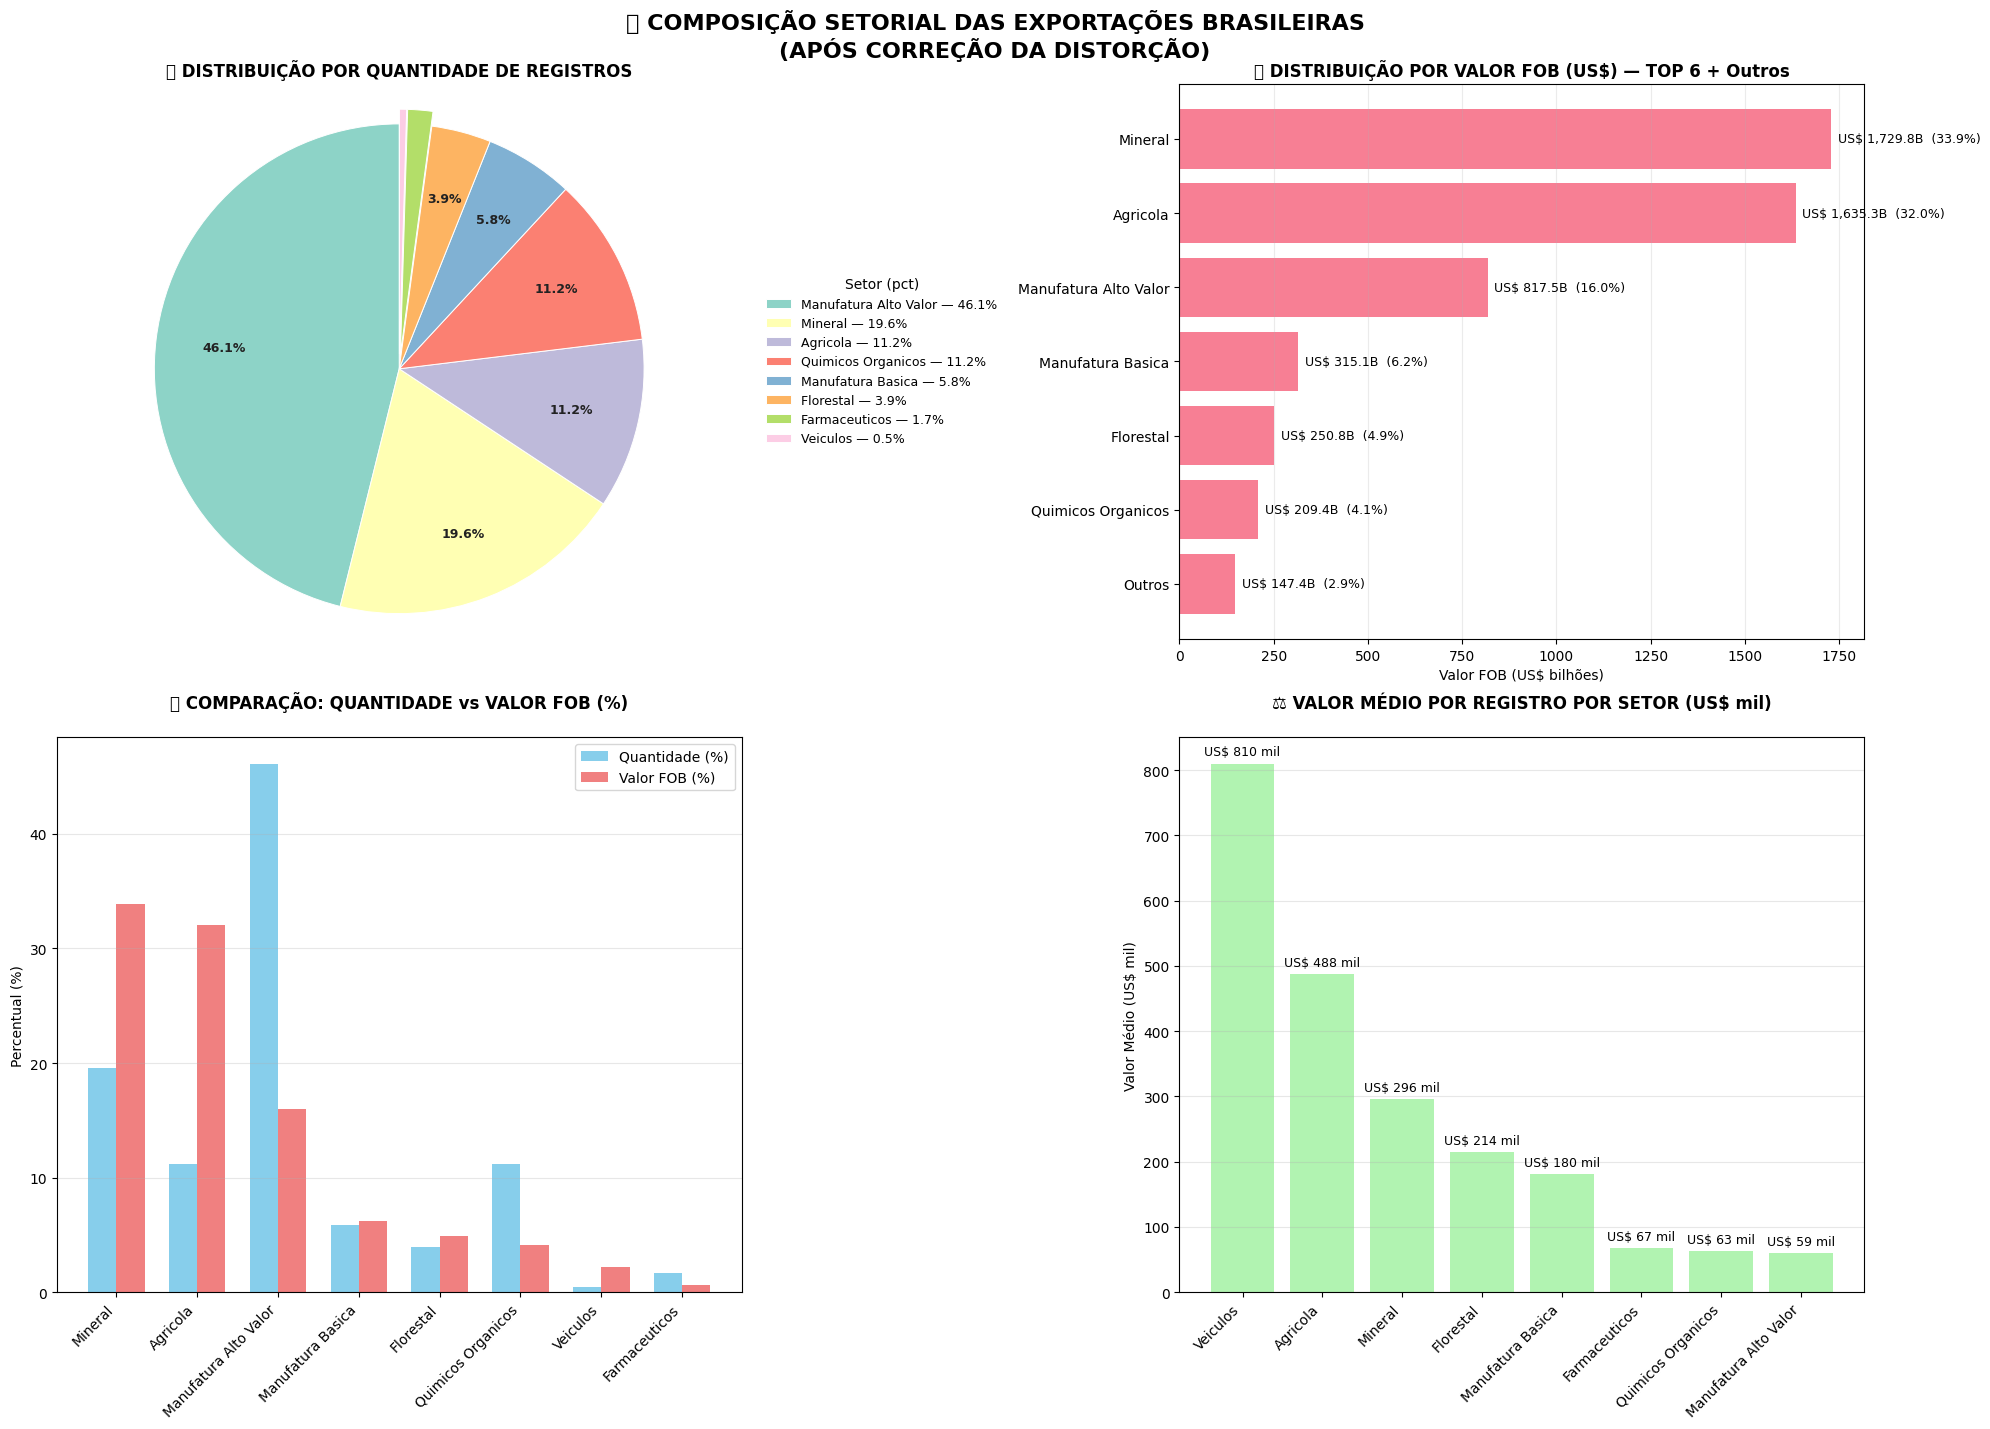

📅 GERANDO GRÁFICO DE EVOLUÇÃO TEMPORAL...


C:\Users\noahs\AppData\Local\Temp\ipykernel_20780\1770245.py:306: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(caminho_evolucao, dpi=300, bbox_inches='tight')


💾 Gráfico de evolução salvo em: C:\Users\noahs\Área de Trabalho\DATASET NOAH_KATAMAK\ANALISE_ARTIGO 01\GRAFICO_EVOLUCAO_TEMPORAL_OTIMIZADO.png


C:\Users\noahs\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


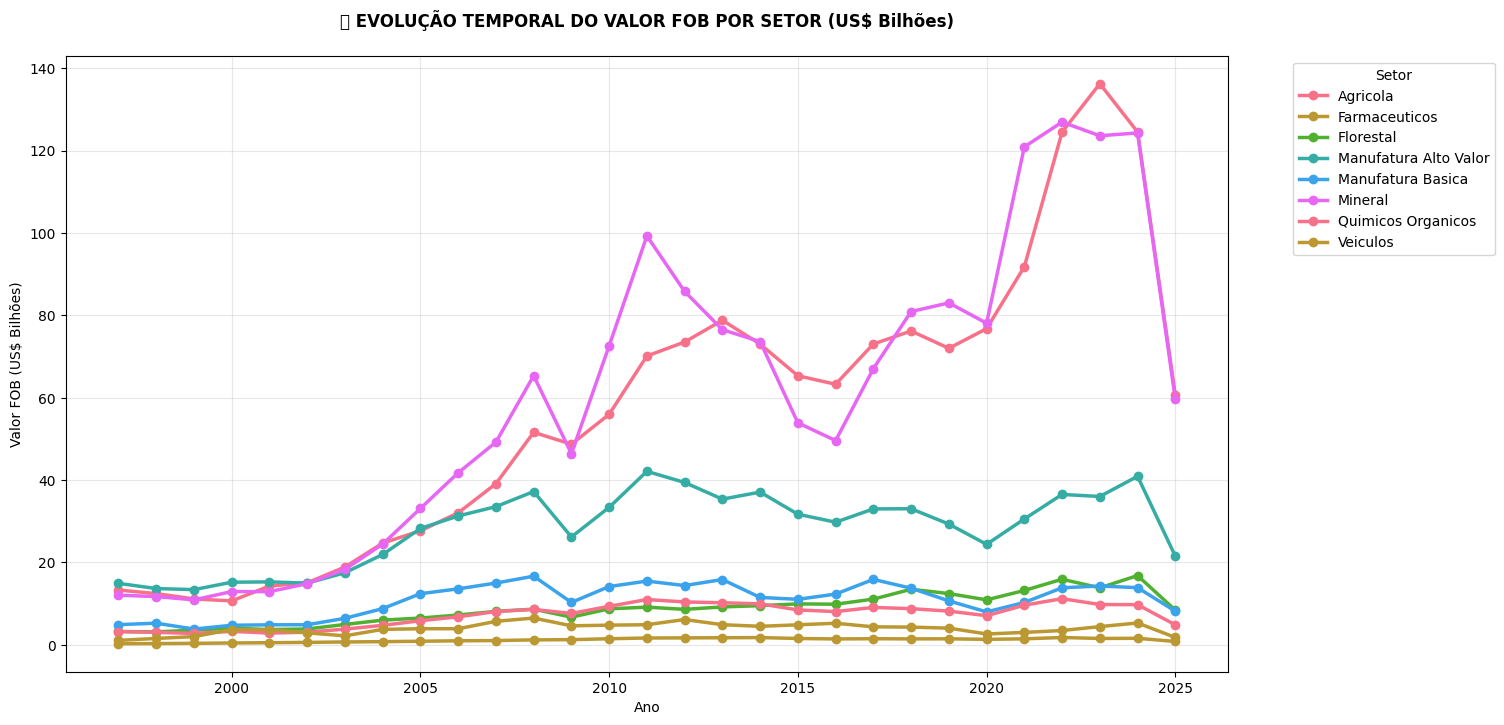


📈 RESUMO ESTATÍSTICO FINAL

📊 TOTAL DE REGISTROS: 29,860,674
💰 VALOR FOB TOTAL: US$ 5,105,168,627,655 (US$ 5105.17 bilhões)

🔍 DETALHAMENTO POR SETOR:
   - Mineral:
       📦 Registros: 5,845,812 (19.6%)
       💰 Valor FOB: US$ 1729.77B (33.9%)
       ⚖️  Valor médio: US$ 295,900

   - Agricola:
       📦 Registros: 3,353,034 (11.2%)
       💰 Valor FOB: US$ 1635.26B (32.0%)
       ⚖️  Valor médio: US$ 487,697

   - Manufatura Alto Valor:
       📦 Registros: 13,773,279 (46.1%)
       💰 Valor FOB: US$ 817.46B (16.0%)
       ⚖️  Valor médio: US$ 59,351

   - Manufatura Basica:
       📦 Registros: 1,746,644 (5.8%)
       💰 Valor FOB: US$ 315.08B (6.2%)
       ⚖️  Valor médio: US$ 180,393

   - Florestal:
       📦 Registros: 1,171,416 (3.9%)
       💰 Valor FOB: US$ 250.80B (4.9%)
       ⚖️  Valor médio: US$ 214,101

   - Quimicos Organicos:
       📦 Registros: 3,335,168 (11.2%)
       💰 Valor FOB: US$ 209.42B (4.1%)
       ⚖️  Valor médio: US$ 62,791

   - Veiculos:
       📦 Registros: 140,8

In [20]:
# =============================================================================
# 📊 GRÁFICOS DA COMPOSIÇÃO SETORIAL - VERSÃO OTIMIZADA (BLOCO CORRIGIDO)
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Configurar estilo dos gráficos
plt.style.use('default')
sns.set_palette("husl")

def processar_dados_para_graficos(pasta_base):
    """
    Processa o arquivo em chunks para evitar problemas de memória
    """
    print("📊 PROCESSANDO DADOS PARA GRÁFICOS EM CHUNKS...")
    
    caminho_corrigido = os.path.join(pasta_base, 'EXPORTACOES_CLASSIFICADAS_CORRIGIDAS_FINAL.csv')
    
    # Inicializar estruturas para agregação
    contagem_setores = {}
    valor_total_setores = {}
    valor_por_ano_setor = {}
    
    chunk_size = 50000  # Processar em chunks menores
    
    try:
        # Processar em chunks
        for i, chunk in enumerate(pd.read_csv(caminho_corrigido, sep=';', encoding='utf-8-sig', 
                                            chunksize=chunk_size, low_memory=False)):
            print(f"📦 Processando chunk {i+1} para agregação...")
            
            # Agregar dados do chunk
            for setor in chunk['setor'].unique():
                mask = chunk['setor'] == setor
                contagem = mask.sum()
                valor_total = chunk.loc[mask, 'VL_FOB'].sum()
                
                # Atualizar contagem
                if setor in contagem_setores:
                    contagem_setores[setor] += contagem
                    valor_total_setores[setor] += valor_total
                else:
                    contagem_setores[setor] = contagem
                    valor_total_setores[setor] = valor_total
            
            # Agregar por ano se a coluna existir
            if 'CO_ANO' in chunk.columns:
                for (ano, setor), group in chunk.groupby(['CO_ANO', 'setor']):
                    chave = (ano, setor)
                    if chave in valor_por_ano_setor:
                        valor_por_ano_setor[chave] += group['VL_FOB'].sum()
                    else:
                        valor_por_ano_setor[chave] = group['VL_FOB'].sum()
                        
    except Exception as e:
        print(f"❌ Erro ao processar: {e}")
        # Tentar com encoding alternativo
        try:
            contagem_setores = {}
            valor_total_setores = {}
            valor_por_ano_setor = {}
            
            for i, chunk in enumerate(pd.read_csv(caminho_corrigido, sep=';', encoding='latin-1', 
                                                chunksize=chunk_size, low_memory=False)):
                print(f"📦 Processando chunk {i+1} (latin-1) para agregação...")
                
                for setor in chunk['setor'].unique():
                    mask = chunk['setor'] == setor
                    contagem = mask.sum()
                    valor_total = chunk.loc[mask, 'VL_FOB'].sum()
                    
                    if setor in contagem_setores:
                        contagem_setores[setor] += contagem
                        valor_total_setores[setor] += valor_total
                    else:
                        contagem_setores[setor] = contagem
                        valor_total_setores[setor] = valor_total
                        
                if 'CO_ANO' in chunk.columns:
                    for (ano, setor), group in chunk.groupby(['CO_ANO', 'setor']):
                        chave = (ano, setor)
                        if chave in valor_por_ano_setor:
                            valor_por_ano_setor[chave] += group['VL_FOB'].sum()
                        else:
                            valor_por_ano_setor[chave] = group['VL_FOB'].sum()
                            
        except Exception as e2:
            print(f"❌ Erro crítico: {e2}")
            return None, None, None
    
    return contagem_setores, valor_total_setores, valor_por_ano_setor

def gerar_graficos_otimizados(pasta_base):
    """
    Gera gráficos usando dados agregados (sem carregar arquivo completo)
    """
    print("🎨 GERANDO GRÁFICOS OTIMIZADOS...")
    
    # Processar dados agregados
    contagem_setores, valor_total_setores, valor_por_ano_setor = processar_dados_para_graficos(pasta_base)
    
    if contagem_setores is None:
        print("❌ Não foi possível processar os dados")
        return
    
    # Converter para Series para facilitar manipulação
    distribuicao_quantidade = pd.Series(contagem_setores)
    distribuicao_valor = pd.Series(valor_total_setores)
    
    total_registros = distribuicao_quantidade.sum()
    total_valor = distribuicao_valor.sum()
    
    print(f"✅ Dados processados: {total_registros:,} registros, US$ {total_valor:,.0f}")
    
    # Criar figura com subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('📈 COMPOSIÇÃO SETORIAL DAS EXPORTAÇÕES BRASILEIRAS\n(APÓS CORREÇÃO DA DISTORÇÃO)', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # =========================================================================
    # GRÁFICO 1: Distribuição por Quantidade de Registros (ajustado para evitar sobreposição)
    # =========================================================================
    axes[0, 0].clear()

    # Ordenar para manter consistência visual
    series_q = distribuicao_quantidade.sort_values(ascending=False)
    sizes = series_q.values
    labels = series_q.index.tolist()

    # Percentuais usados para decisão de rótulos/explode
    percentages = (sizes / total_registros) * 100 if total_registros > 0 else np.zeros_like(sizes)

    # Explode em fatias muito pequenas para separá-las visualmente
    explode = [0.06 if p < 3 else 0 for p in percentages]  # explodir fatias menores que 3%

    # Função para mostrar porcentagem apenas quando for significativa (>= 3%)
    def _autopct(pct):
        return f'{pct:.1f}%' if pct >= 3 else ''

    # Desenhar a pizza sem labels diretas (vamos usar legenda lateral)
    wedges, texts, autotexts = axes[0, 0].pie(
        sizes,
        labels=None,
        autopct=_autopct,
        startangle=90,
        explode=explode,
        pctdistance=0.72,
        labeldistance=1.05,
        wedgeprops=dict(edgecolor='white', linewidth=0.7),
        colors=plt.cm.Set3.colors
    )

    # Ajustes de estilo nos textos de percentuais internos
    for txt in autotexts:
        txt.set_fontsize(9)
        txt.set_weight('bold')
        txt.set_color('#222222')

    axes[0, 0].set_title('📋 DISTRIBUIÇÃO POR QUANTIDADE DE REGISTROS', fontweight='bold')

    # Garantir aspecto circular
    axes[0, 0].axis('equal')

    # Criar legenda lateral com nome do setor + percentual (evita sobreposição)
    legend_labels = [f"{lab} — {pct:.1f}%" for lab, pct in zip(labels, percentages)]
    axes[0, 0].legend(
        wedges,
        legend_labels,
        title='Setor (pct)',
        bbox_to_anchor=(1.02, 0.5),
        loc='center left',
        fontsize=9,
        frameon=False
    )

    # =========================================================================
    # GRÁFICO 2: Distribuição por Valor FOB (US$) - BARRAS HORIZONTAIS
    # =========================================================================
    # Ordenar por valor decrescente e manter para uso posterior
    distribuicao_valor_ordenada = distribuicao_valor.sort_values(ascending=False)

    # Agrupar fatias pequenas em "Outros" para clareza
    top_n = 6
    if len(distribuicao_valor_ordenada) > top_n:
        top = distribuicao_valor_ordenada.iloc[:top_n].copy()
        outros = distribuicao_valor_ordenada.iloc[top_n:].sum()
        top['Outros'] = outros
        plot_series = top
    else:
        plot_series = distribuicao_valor_ordenada

    # Percentuais para anotação
    percentuais = (plot_series / total_valor) * 100

    # Gráfico de barras horizontal
    ax = axes[0, 1]
    ax.clear()
    y_pos = np.arange(len(plot_series))
    bars = ax.barh(y_pos, plot_series.values / 1e9, align='center', alpha=0.9)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_series.index, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('Valor FOB (US$ bilhões)', fontsize=10)
    ax.set_title(f'💰 DISTRIBUIÇÃO POR VALOR FOB (US$) — TOP {top_n} + Outros', fontweight='bold')

    # Anotar cada barra com valor absoluto e percentual
    max_bil = max(plot_series.values / 1e9) if len(plot_series) > 0 else 0.0
    for i, (val_bil, pct) in enumerate(zip(plot_series.values / 1e9, percentuais)):
        ax.text(val_bil + max_bil * 0.01, i,
                f'US$ {val_bil:,.1f}B  ({pct:.1f}%)',
                va='center', fontsize=9)

    ax.xaxis.grid(True, alpha=0.25)

    # =========================================================================
    # GRÁFICO 3: Barras - Comparação Quantidade vs Valor
    # =========================================================================
    # Normalizar os dados para comparação
    quantidade_normalizada = (distribuicao_quantidade / total_registros) * 100 if total_registros > 0 else distribuicao_quantidade * 0
    valor_normalizado = (distribuicao_valor / total_valor) * 100 if total_valor > 0 else distribuicao_valor * 0
    
    # Garantir mesma ordem para ambos (usar a ordenação por valor)
    setores_ordenados = distribuicao_valor_ordenada.index
    quantidade_ordenada = quantidade_normalizada.reindex(setores_ordenados).fillna(0)
    valor_ordenado = valor_normalizado.reindex(setores_ordenados).fillna(0)
    
    x = np.arange(len(setores_ordenados))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, quantidade_ordenada, width, label='Quantidade (%)', color='skyblue')
    axes[1, 0].bar(x + width/2, valor_ordenado, width, label='Valor FOB (%)', color='lightcoral')
    
    axes[1, 0].set_title('📊 COMPARAÇÃO: QUANTIDADE vs VALOR FOB (%)\n', fontweight='bold')
    axes[1, 0].set_ylabel('Percentual (%)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(setores_ordenados, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # =========================================================================
    # GRÁFICO 4: Valor Médio por Registro por Setor (US$)
    # =========================================================================
    # Evitar divisão por zero
    qtd_nonzero = distribuicao_quantidade.replace(0, np.nan)
    valor_medio_setor = (distribuicao_valor / qtd_nonzero).fillna(0).sort_values(ascending=False)
    valor_medio_setor_mil = valor_medio_setor / 1000  # Converter para milhares
    
    bars = axes[1, 1].bar(range(len(valor_medio_setor)), valor_medio_setor_mil.values, 
                         color='lightgreen', alpha=0.7)
    axes[1, 1].set_title('⚖️ VALOR MÉDIO POR REGISTRO POR SETOR (US$ mil)\n', fontweight='bold')
    axes[1, 1].set_ylabel('Valor Médio (US$ mil)')
    axes[1, 1].set_xticks(range(len(valor_medio_setor)))
    axes[1, 1].set_xticklabels(valor_medio_setor.index, rotation=45, ha='right')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    max_mil = max(valor_medio_setor_mil.values) if len(valor_medio_setor_mil) > 0 else 0.0
    for i, (bar, valor) in enumerate(zip(bars, valor_medio_setor_mil.values)):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + max_mil * 0.01,
                       f'US$ {valor:,.0f} mil', ha='center', va='bottom', fontsize=9)
    
    # Ajustar layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    
    # Salvar gráfico
    caminho_grafico = os.path.join(pasta_base, 'GRAFICO_COMPOSICAO_SETORIAL_OTIMIZADO.png')
    plt.savefig(caminho_grafico, dpi=300, bbox_inches='tight')
    print(f"💾 Gráfico principal salvo em: {caminho_grafico}")
    
    plt.show()
    
    # =========================================================================
    # GRÁFICO ADICIONAL: Evolução Temporal (se dados disponíveis)
    # =========================================================================
    if valor_por_ano_setor:
        print("📅 GERANDO GRÁFICO DE EVOLUÇÃO TEMPORAL...")
        
        # Converter para DataFrame
        dados_evolucao = []
        for (ano, setor), valor in valor_por_ano_setor.items():
            dados_evolucao.append({'Ano': ano, 'Setor': setor, 'Valor_FOB': valor})
        
        df_evolucao = pd.DataFrame(dados_evolucao)
        
        # Pivot para formato wide
        evolucao_wide = df_evolucao.pivot_table(index='Ano', columns='Setor', values='Valor_FOB', fill_value=0)
        
        # Converter para bilhões
        evolucao_wide_bilhoes = evolucao_wide / 1e9
        
        plt.figure(figsize=(15, 8))
        evolucao_wide_bilhoes.plot(kind='line', marker='o', linewidth=2.5, markersize=6, ax=plt.gca())
        plt.title('📈 EVOLUÇÃO TEMPORAL DO VALOR FOB POR SETOR (US$ Bilhões)\n', fontweight='bold')
        plt.xlabel('Ano')
        plt.ylabel('Valor FOB (US$ Bilhões)')
        plt.grid(True, alpha=0.3)
        plt.legend(title='Setor', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        caminho_evolucao = os.path.join(pasta_base, 'GRAFICO_EVOLUCAO_TEMPORAL_OTIMIZADO.png')
        plt.savefig(caminho_evolucao, dpi=300, bbox_inches='tight')
        print(f"💾 Gráfico de evolução salvo em: {caminho_evolucao}")
        
        plt.show()
    
    # =========================================================================
    # RESUMO ESTATÍSTICO
    # =========================================================================
    print("\n" + "="*60)
    print("📈 RESUMO ESTATÍSTICO FINAL")
    print("="*60)
    
    print(f"\n📊 TOTAL DE REGISTROS: {total_registros:,}")
    print(f"💰 VALOR FOB TOTAL: US$ {total_valor:,.0f} (US$ {total_valor/1e9:.2f} bilhões)")
    
    print("\n🔍 DETALHAMENTO POR SETOR:")
    for setor in distribuicao_valor_ordenada.index:
        qtd = int(distribuicao_quantidade.get(setor, 0))
        valor = float(distribuicao_valor.get(setor, 0.0))
        valor_medio = valor / qtd if qtd > 0 else 0
        perc_valor = (valor / total_valor) * 100 if total_valor > 0 else 0
        perc_qtd = (qtd / total_registros) * 100 if total_registros > 0 else 0
        
        print(f"   - {setor}:")
        print(f"       📦 Registros: {qtd:,} ({perc_qtd:.1f}%)")
        print(f"       💰 Valor FOB: US$ {valor/1e9:.2f}B ({perc_valor:.1f}%)")
        print(f"       ⚖️  Valor médio: US$ {valor_medio:,.0f}")
        print()

# Executar a geração dos gráficos
pasta_base = r"C:\Users\noahs\Área de Trabalho\DATASET NOAH_KATAMAK\ANALISE_ARTIGO 01"
gerar_graficos_otimizados(pasta_base)

print("🎉 ANÁLISE GRÁFICA CONCLUÍDA!")
